# K-Nearest Neighbor Lab





In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import pip
# pip.main(["install","matplotlib"])
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
import math
from scipy.spatial import distance


## 1. (40%) Correctly implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors. 
- Include optional distance weighting for both algorithms


In [18]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, columnType='categorical', pred_type='categoritcal', weight_type='inverse_distance', k_val=3): ## add parameters here
        """
        Args:
            columnType for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.pred_type = pred_type #Note This won't be needed until part 5
        self.weight_type = weight_type
        self.k_val = k_val
        self.columnType = columnType

    def fit(self, data, labels):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.train_data = data
        self.train_labels = labels
        return self
    
    def predict(self, data):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        if self.columnType == 'categorical':
            
        preds = []  
        for i in range(len(data)):
            dist_arr = np.linalg.norm(data[i] - self.train_data, axis=1)
            sorted_dist = np.argsort(dist_arr)
            k_nearest = [[math.inf, 0] for x in range(self.k_val)]
            for k in range(self.k_val):
                dist = dist_arr[sorted_dist[k]]
                lbl = self.train_labels[sorted_dist[k]]
                add = [dist, lbl]
                k_nearest[k] = add
            preds.append(self.predict_output(k_nearest))
        return preds

    def predict_output(self, k_near):
        # if predict val is real, do regression
        if self.pred_type == 'real':
            # return the mean of the regression labels
            if self.weight_type != 'inverse_distance':
                label_sum=0
                for i in range(len(k_near)):
                    label_sum+=k_near[i][1]
                return label_sum/len(k_near)
            # use the sum equation
            else:
                numerator = 0
                denominator = 0
                for i in range(len(k_near)):
                    numerator+=(k_near[i][1]/(k_near[i][0]**2))
                    denominator+=(1/(k_near[i][0]**2))
                return numerator/denominator
        # categorical predicting values
        else:
            votes = {}
            for i in range(len(k_near)):
                label = k_near[i][1]
                dist =  k_near[i][0]
                # if label is already in our dict
                if label in votes:
                    #inverse distance calculation
                    if self.weight_type == 'inverse_distance':
                        inv_dist = 1/dist**2
                        votes[label] += inv_dist
                    else:
                        votes[label] +=1
                # add label to our dict
                else:
                    #inverse distance calculation
                    if self.weight_type == 'inverse_distance':
                        inv_dist = 1/dist**2
                        votes[label] = inv_dist
                    else:
                        votes[label] = 1
            # choose the winner
            max_val = 0
            label = ''
            for key, value in votes.items():
                if value > max_val or max_val == 0:
                    label = key
                    max_val = value
                # tie
                elif value == max_val:
                    label = min(key, label)
                    max_val = value = votes[label]

        return label

    #Returns the Mean score given input data and labels
    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        predictions = self.predict(X)
        # return MSE
        if self.pred_type == 'real':
            sum_err = 0
            for idx, pred in enumerate(predictions):
                err = ((y[idx] - pred)**2)
                sum_err += err
            return sum_err/len(X)
        # return percent correct
        else:
            correct = 0
            for i, pred in enumerate(predictions):
                if pred == y[i]:
                    correct +=1
            return correct/len(X)
    

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below:

- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

---

### 1.1.1 Debug

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_test.arff)
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

Expected Results:
- Not using inverse weighted distancing = roughly [68.29%]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/glass_no_inv_predictions.txt)

- Using inverse weighted distancing = roughly [74.39%]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/glass_inv_predictions.txt)


In [5]:
def convertBytestoString(df):
  for col in df:
    if isinstance(df[col][0], bytes):
      df[col] = df[col].str.decode("utf8")
  return df

In [6]:
# Load glass data
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_train.arff --output debug.arff
# Train on training set
debug_data = arff.loadarff('debug.arff')
debug_df = convertBytestoString(pd.DataFrame(debug_data[0]))
debug_np = np.array(debug_df)
clf = KNNClassifier(weight_type='no_weight')
train =  np.array(debug_np[:,0:-1]).astype(float)
targets = debug_np[:,-1]
res = clf.fit(train, targets)


# Predict on test set
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_test.arff --output debug_test.arff
debug_test = arff.loadarff('debug_test.arff')
debug_test_df = convertBytestoString(pd.DataFrame(debug_test[0]))
debug_test_np = np.array(debug_test_df)
debug_test_inputs = np.array(debug_test_np[:,0:-1]).astype(float)
debug_test_targets = debug_test_np[:,-1]
acc = res.score(debug_test_inputs, debug_test_targets)
print('acc not using weighted distancing: ', acc)

# using inverse weighted distancing
clf = KNNClassifier(weight_type='inverse_distance')
id_res = clf.fit(train, targets)
id_acc = id_res.score(debug_test_inputs, debug_test_targets)
print('acc using weighted distancing: ', id_acc)



acc not using weighted distancing:  0.6829268292682927
acc using weighted distancing:  0.7439024390243902


### 1.1.2 Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff)

In [7]:
# Load diabetes data
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff --output diab.arff
# Train on training set
diab = arff.loadarff('diab.arff')
diab_df = convertBytestoString(pd.DataFrame(diab[0]))
diab_np = np.array(diab_df)
clf = KNNClassifier(weight_type='no_weight', columntype='categoritcal')
diab_inputs =  np.array(diab_np[:,0:-1]).astype(float)
diab_targets = diab_np[:,-1]
res = clf.fit(diab_inputs, diab_targets)


# Predict on test set
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff --output diab_test.arff
diab_test = arff.loadarff('diab_test.arff')
diab_test_df = convertBytestoString(pd.DataFrame(diab_test[0]))
diab_test_np = np.array(diab_test_df)
diab_test_inputs = np.array(diab_test_np[:,0:-1]).astype(float)
diab_test_targets = diab_test_np[:,-1]
acc = res.score(diab_test_inputs, diab_test_targets)
print('acc not using weighted distancing: ', acc)


acc not using weighted distancing:  0.8411458333333334


In [8]:
def normalize_vals(inputs):
  xmin = inputs.min(axis=0)
  xmax = inputs.max(axis=0)
  return (inputs-xmin)/(xmax-xmin)

## 2. (10%) Use the k-nearest neighbor algorithm (without distance weighting) for the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) problem

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff) 

### 2.1
- Try it with k=3 and without normalization


In [10]:
# Load magic telescope data
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output tel.arff
# Train on training set
tel = arff.loadarff('tel.arff')
tel_df = convertBytestoString(pd.DataFrame(tel[0]))
tel_np = np.array(tel_df)

# Train/Predict without normalization
clf = KNNClassifier(weight_type='no_weight')
tel_inputs = np.array(tel_np[:,0:-1]).astype(float)
tel_targets = np.array(tel_np[:,-1])
res = clf.fit(tel_inputs, tel_targets)

# Predict on test set
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output tel_test.arff
tel_test = arff.loadarff('tel_test.arff')
tel_test_df = convertBytestoString(pd.DataFrame(tel_test[0]))
tel_test_np = np.array(tel_test_df)
tel_test_inputs = np.array(tel_test_np[:,0:-1]).astype(float)
tel_test_targets = tel_test_np[:,-1]
acc = res.score(tel_test_inputs, tel_test_targets)
print('acc not using weighted distancing: ', acc)



acc not using weighted distancing:  0.8082808280828083


### 2.2
- Try it with k=3 and with normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [11]:
# Train/Predict with normalization
tel_norm_inputs = normalize_vals(tel_inputs)
tel_norm_test_inputs = normalize_vals(tel_test_inputs)
# Train/Predict without normalization
res = clf.fit(tel_norm_inputs, tel_targets)

# Predict on test set
acc = res.score(tel_norm_test_inputs, tel_test_targets)
print('acc normalizing input features: ', acc)

acc normalizing input features:  0.8157815781578158


*Discuss the accuracy results of using normalized data vs. unnormalized data*

### 2.3

- Using your normalized data, create one graph with classification accuracy on the test set over k values. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

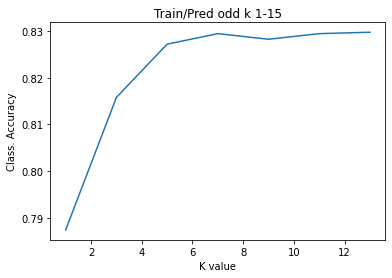

[0.7874287428742874, 0.8157815781578158, 0.8271827182718272, 0.8294329432943295, 0.8282328232823283, 0.8294329432943295, 0.8297329732973298]


In [14]:
# Train/Predict with normalization using k=1,3,...,15
k_class_acc = []
x_v = []
for i in range(1, 15, 2):
  x_v.append(i)
  clf = KNNClassifier(weight_type='no_weight', k_val=i)
  res = clf.fit(tel_norm_inputs, tel_targets)
  k_class_acc.append(res.score(tel_norm_test_inputs, tel_test_targets))

# Graph classification accuracy over k
plt.plot(x_v, k_class_acc)
plt.title("Magic Telescope Train/Pred odd k 1-15")
plt.xlabel("K value")
plt.ylabel("Class. Accuracy")
plt.show()
print(k_class_acc)

# For the rest of the experiments use only normalized data

## 3. (10%) Use the regression variation of your algorithm (without distance weighting) for the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff).
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case.
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15


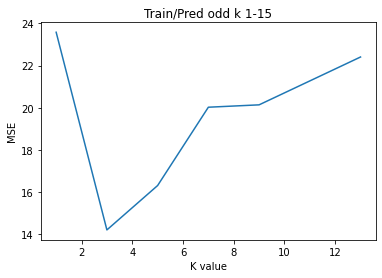

[23.580980392156874, 14.215446623093682, 16.31825882352942, 20.028679471788713, 20.141234567901236, 21.274496840058337, 22.408194686158495]


In [101]:
# Load housing price prediction data
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output housing.arff
housing = arff.loadarff('housing.arff')
housing_df = convertBytestoString(pd.DataFrame(housing[0]))
housing_np = np.array(housing_df).astype(float)
# normalize values
norm_inputs = normalize_vals(housing_np[:,0:-1])
housing_norm_inputs = np.array(norm_inputs)
housing_targets = np.array(housing_np[:,-1])


!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output housing_test.arff
housing_test = arff.loadarff('housing_test.arff')
housing_test_df = convertBytestoString(pd.DataFrame(housing_test[0]))
housing_test_np = np.array(housing_test_df).astype(float)
# normalize values
norm_test_inputs = normalize_vals(housing_test_np[:,0:-1])
housing_norm_test_inputs = np.array(norm_test_inputs)
housing_test_targets = np.array(housing_test_np[:,-1])


# Train/Predict using k=1,3,...,15
k_MSE = []
x_v = []
for i in range(1, 15, 2):
  x_v.append(i)
  clf = KNNClassifier(pred_type='real', weight_type='no_weight', k_val=i)
  res = clf.fit(housing_norm_inputs, housing_targets)
  k_MSE.append(res.score(housing_norm_test_inputs, housing_test_targets))

# Graph MSE over k
plt.plot(x_v, k_MSE)
plt.title("Housing Train/Pred odd k 1-15")
plt.xlabel("K value")
plt.ylabel("MSE")
plt.show()
print(k_MSE)


## 4. (15%) Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.


## 4.1 Magic Telescope Dataset

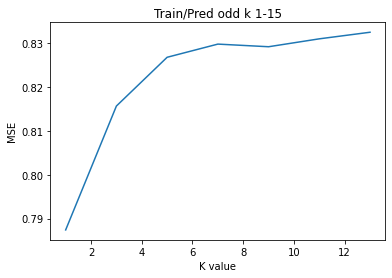

[0.7874287428742874, 0.8156315631563157, 0.8267326732673267, 0.8297329732973298, 0.8291329132913291, 0.830933093309331, 0.8324332433243324]


In [102]:
# Train/Predict magic telescope using distance-weighted voting

# Train/Predict using k=1,3,...,15
k_acc = []
x_v = []
for i in range(1, 15, 2):
  x_v.append(i)
  clf = KNNClassifier(weight_type='inverse_distance', k_val=i)
  res = clf.fit(tel_norm_inputs, tel_targets)
  k_acc.append(res.score(tel_norm_test_inputs, tel_test_targets))

# Graph MSE over k
plt.plot(x_v, k_acc)
plt.title("Magic Telescope Inverse Distance Train/Pred odd k 1-15")
plt.xlabel("K value")
plt.ylabel("MSE")
plt.show()
print(k_acc)

## 4.2 Housing Dataset

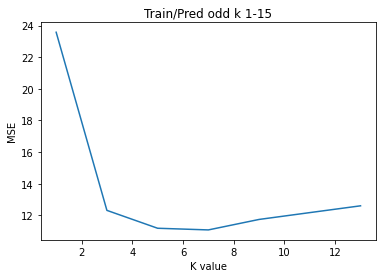

[23.580980392156878, 12.310558867751297, 11.179088494440384, 11.073892657897748, 11.736722469473246, 12.16907932184446, 12.59875781625799]


In [103]:
# Train/Predict using k=1,3,...,15
k_MSE = []
x_v = []
for i in range(1, 15, 2):
  x_v.append(i)
  clf = KNNClassifier(pred_type='real', weight_type='inverse_distance', k_val=i)
  res = clf.fit(housing_norm_inputs, housing_targets)
  k_MSE.append(res.score(housing_norm_test_inputs, housing_test_targets))

# Graph MSE over k
plt.plot(x_v, k_MSE)
plt.title("Housing Inverse Distance Train/Pred odd k 1-15")
plt.xlabel("K value")
plt.ylabel("MSE")
plt.show()
print(k_MSE)


*Discuss your results*

## 5. (10%) Use the k-nearest neighbor algorithm to solve the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) (credit-a) problem.

- Use this [dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.


In [21]:
# replace unknown
# replacing with mode of the column
def replaceUnknownVals(data):
  mode = data.mode().to_numpy().flatten()
  col_num = len(data.columns.to_numpy())

  data_arr = data.to_numpy()
  for i in range(len(data_arr)):
    for j in range(col_num):
      if data_arr[i][j] == '?':
        data_arr[i][j] = mode[j]
      if data_arr[i][j] == np.nan:
        data_arr[i][j] = mode[j]
  return data_arr

In [23]:
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff --output credit.arff
# Train/Predict credit-approval
credit = arff.loadarff('credit.arff')
credit_df = convertBytestoString(pd.DataFrame(credit[0]))
credit_np = np.array(replaceUnknownVals(credit_df))

# Train/Predict without normalization
clf = KNNClassifier(weight_type='no_weight', columnType='categoritcal')
credit_inputs = np.array(credit_np[:,0:-1])
credit_targets = np.array(credit_np[:,-1])
res = clf.fit(credit_inputs, credit_targets)

*Explain and justify your distance metric*

## 6. (15%) Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare your results.

- Try out different hyperparameters to see how well you can do. 


In [114]:
# Train/Predict magic telescope using scikit's KNN
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(tel_inputs, tel_targets)
print(neigh.score(tel_test_inputs, tel_test_targets))
# Train/Predict housing using scikit's KNN
neigh_1 = KNeighborsRegressor(n_neighbors=3)
neigh_1.fit(housing_norm_inputs, housing_targets)
print(neigh_1.score(housing_norm_test_inputs, housing_test_targets))

0.8082808280828083
0.81451663365283


*Report your comparison*

## 7. (optional 5% extra credit): For the best value of k for any one of the datasets, implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.

- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. How well does your reduction algorithm work?
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n2 at each step.
    - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - More information on reduction techniques can be found [here](http://axon.cs.byu.edu/~martinez/classes/478/slides/IBL.pdf).
